# imports

In [174]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
import torch.nn as nn
import numpy as np
import random 
import matplotlib.pyplot as plt
from torchvision import models
from torchsummary import summary

from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import gunpowder as gp
import zarr
import math
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter
import skimage
import networkx
import pathlib
from tifffile import imread, imwrite
import tensorboard
import torch.nn.functional as F
import glob

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Define model

In [2]:
class Vgg3D(torch.nn.Module):

    def __init__(self, input_size, output_classes, downsample_factors, fmaps=12):

        super(Vgg3D, self).__init__()

        self.input_size = input_size
        self.downsample_factors = downsample_factors
        self.output_classes = 2

        current_fmaps, h, w, d = tuple(input_size)
        current_size = (h, w,d)

        features = []
        for i in range(len(downsample_factors)):

            features += [
                torch.nn.Conv3d(current_fmaps,fmaps,kernel_size=3,padding=1),
                torch.nn.BatchNorm3d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv3d(fmaps,fmaps,kernel_size=3,padding=1),
                torch.nn.BatchNorm3d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.MaxPool3d(downsample_factors[i])
            ]

            current_fmaps = fmaps
            fmaps *= 2

            size = tuple(
                int(c/d)
                for c, d in zip(current_size, downsample_factors[i]))
            check = (
                s*d == c
                for s, d, c in zip(size, downsample_factors[i], current_size))
            assert all(check), \
                "Can not downsample %s by chosen downsample factor" % \
                (current_size,)
            current_size = size

        self.features = torch.nn.Sequential(*features)

        classifier = [
            torch.nn.Linear(current_size[0] *current_size[1]*current_size[2] *current_fmaps,4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096,4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096,output_classes)
        ]

        self.classifier = torch.nn.Sequential(*classifier)
    
    def forward(self, raw):

        # add a channel dimension to raw
        # shape = tuple(raw.shape)
        # raw = raw.reshape(shape[0], 1, shape[1], shape[2])
        
        # compute features
        f = self.features(raw)
        f = f.view(f.size(0), -1)
        
        # classify
        y = self.classifier(f)

        return y

In [3]:
input_size = (1, 64, 64, 5)
downsample_factors =[(2, 2, 1), (2, 2, 1), (2, 2, 1), (2, 2, 1)];
output_classes = 12

# create the model to train
model = Vgg3D(input_size, output_classes,  downsample_factors = downsample_factors)
model = model.to(device)

#summary(model, input_size)

# Loss functions

In [18]:
loss_function = torch.nn.CosineEmbeddingLoss()
#loss_function = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)

# load model state file

In [186]:
# path to state file
modelstateP = '/mnt/shared/celltracking/modelstates/aaron/'
stateFile = 'epoch_27'

model.load_state_dict(torch.load(modelstateP+stateFile))
model.eval()

Vgg3D(
  (features): Sequential(
    (0): Conv3d(1, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(12, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0, dilation=1, ceil_mode=False)
    (7): Conv3d(12, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (11): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), 

# convert data to zarr

In [176]:
### Convert data into zarr format
def tif2zarr(baseDir,groupKey,outDir='',chunkSize=48):
    if outDir=='':
        outDir = baseDir+"/zarr/"
    
    # load all tiff files 
    img = np.stack([imread(xi) for xi in sorted(glob.glob(baseDir+"/"+"*.tif"))])  # images

    # format: [timepoints,zslices,y,z]
    imDims = img.shape
    
    # define chunk size
    if isinstance(chunkSize, int):
        chunks = np.repeat(chunkSize,len(imDims))
    else:
        chunks = chunkSize
                  
    # write img into zarr file       
    #zFile = zarr.open(outDir, shape=imDims, chunks=chunks, mode="w", dtype='int32')
    store = zarr.DirectoryStore(outDir)
    zFile = zarr.open_group(store=store,mode='w')
        
    zGroup = zFile.create_dataset(groupKey, shape=imDims,chunks=chunks,dtype='int32')
    #zFile = zarr.open_group(outDir+"/"+groupKey,mode='w',shape=imDims, chunks=chunks, dtype='int32')
    zFile[groupKey] = img
        
    return outDir

dataDir = "/mnt/shared/celltracking/data/cho/02"
zarr_dir = "/mnt/shared/celltracking/data/cho/02.zarr"
zarrdir = tif2zarr(dataDir,'raw',zarr_dir)
print(f'zarr data directory:{zarrdir}')

zarr data directory:/mnt/shared/celltracking/data/cho/02.zarr


# Read tracks from GT

In [306]:
base_path = pathlib.Path("/mnt/shared/celltracking/data/cho/")

# read parent-child links from file
links = np.loadtxt(base_path / "02_GT/TRA" / "man_track.txt", dtype=int)

# read annotated image stack
annotations = np.stack([imread(xi) for xi in sorted((base_path / "02_GT/TRA").glob("*.tif"))])  # images

# extract centroids from annotated image stacks
tracks_raw = []
for t, frame in enumerate(annotations):
    centers = skimage.measure.regionprops(frame)
    for c in centers:
        tracks_raw.append([c.label, t, int(c.centroid[1]), int(c.centroid[2])])
        
# constructs graph 
tracks = np.array(tracks_raw)
graph = networkx.DiGraph()
for cell_id, t, x, y in tracks:
    graph.add_node((cell_id,t), x=x, y=y, t=t)
    
for cell_id, t in graph.nodes():
    if (cell_id, t+1) in graph.nodes():
        graph.add_edge((cell_id, t), (cell_id,t+1))
        

for child_id, child_from, _, child_parent_id in links:
    for parent_id, _, parent_to, _ in links:
        if child_parent_id == parent_id:
            graph.add_edge((parent_id, parent_to), (child_id, child_from))
            
# extract trajectories from graph set
tracks = [graph.subgraph(c) for c in networkx.weakly_connected_components(graph) if len(c)>0]

# remove tracks with 0 edges
tracks = [track for track in tracks if len(track.edges)>0]

In [208]:
for node in graph.nodes():
    if not "x" in graph.nodes[node]:
        print(node)

In [209]:
for i,x in enumerate(tracks):
    print(f'track {i} has {len(tracks[i].edges)} edges')

track 0 has 154 edges
track 1 has 139 edges
track 2 has 103 edges
track 3 has 25 edges
track 4 has 2 edges
track 5 has 2 edges
track 6 has 9 edges
track 7 has 55 edges
track 8 has 4 edges
track 9 has 1 edges
track 10 has 42 edges
track 11 has 39 edges
track 12 has 21 edges


# Define function to make image pairs

In [210]:
class getPaired(gp.BatchFilter):

    def __init__(self, raw, raw_shift, tracks, paired=True):
        self.raw = raw
        self.raw_shift = raw_shift
        self.tracks = tracks
        self.paired = paired
    
    # _ref channel array is stored in raw_ref, while second volume in pair will be stored raw_new
    def prepare(self, request):
        # obtain volume coordinates from tracks                
        deps = gp.BatchRequest()
        vol1,vol2 = self.sampler(request)
                
        deps[self.raw] = gp.ArraySpec(roi=gp.Roi(vol1,request[self.raw].roi.get_shape()))
        deps[self.raw_shift] = gp.ArraySpec(roi=gp.Roi(vol2,request[self.raw_shift].roi.get_shape()))

        return deps
    
    # required to inform downstream nodes about new array 
    def process(self, batch, request):
        # create a new batch to hold the new array
        out_batch = gp.Batch()

        # create new array and store it in the batch
        out_batch[self.raw_shift] = batch[self.raw_shift]
        out_batch[self.raw] = batch[self.raw]
        
        #print(f'raw: {batch[self.raw].spec.roi}')
        #print(batch[self.raw_shift].spec.roi)
        
        # make sure that coordinates for batch[raw] and batch[raw_shift] are reset to (0,0,0,0,0)
        out_batch[self.raw].spec.roi = request[self.raw].roi
        out_batch[self.raw_shift].spec.roi = request[self.raw_shift].roi

        # return the new batch
        return out_batch
    
    # select pairs of subvolumes from data
    def sampler(self,request):
        tracks = self.tracks
        paired = self.paired
        # choose connected nodes
        # if self.paired:
        if paired:
            t0 = tracks[np.random.randint(0,len(tracks),1).item()]
            e0 = list(t0.edges)[np.random.randint(len(list(t0.edges)))]
            node0 = t0.nodes[e0[0]]
            node1 = t0.nodes[e0[1]]
            
        # choose random unconnected nodes
        else:
            # randomly choose two tracks and make sure they are not identical
            t0,t1 = np.random.randint(0,len(tracks),2)
            while t0==t1:
                t0,t1 = np.random.randint(0,len(tracks),2)

            #print(f'trackids: {t0,t1}')
            t0 = tracks[t0]
            t1 = tracks[t1]

            # choose random edges from each track
            #print(f'number edges per track{len(list(t0.nodes)),len(list(t1.nodes))}')

            r0 = np.random.randint(0,len(list(t0.nodes))) 
            r1 = np.random.randint(0,len(list(t1.nodes)))

            node0 = t0.nodes[list(t0.nodes)[r0]]
            node1 = t1.nodes[list(t1.nodes)[r1]]
            


        node0_xyt = [node0["x"], node0["y"], node0["t"]]
        node1_xyt = [node1["x"], node1["y"], node1["t"]]

        #print(f'input coord: {node0_xyt,node1_xyt}')

        roi_in = request[self.raw_shift].roi.get_shape()
        #t,z,y,x
        coords_vol0 = (node0_xyt[2],0,node0_xyt[0]-(roi_in[2]/2),node0_xyt[1]-(roi_in[3]/2))
        coords_vol1 = (node1_xyt[2],0,node1_xyt[0]-(roi_in[2]/2),node1_xyt[1]-(roi_in[3]/2))
        #print(f'output coords - vol0: {coords_vol0}, vol1:{coords_vol1}')

        return coords_vol0, coords_vol1

# gunpowder pipelines

In [211]:
#specify subvolume size and volume source
volSize = (1,5,64, 64)
coord = (0,0,0,0)
batch_size = 8

zarrdir = '/mnt/shared/celltracking/data/cho/02.zarr'
raw = gp.ArrayKey('raw')
raw_shift = gp.ArrayKey('raw_shift')

# create "pipeline" consisting only of a data source and prepare 
pipeline_paired = (gp.ZarrSource(
    zarrdir,  # the zarr container
    {raw_shift: 'raw', raw: 'raw'},  # which dataset to associate to the array key
    {raw_shift: gp.ArraySpec(voxel_size=(1,1,1,1), interpolatable=True), raw:gp.ArraySpec(voxel_size=(1,1,1,1), interpolatable=True)}  # meta-information
    ) + gp.Pad(raw_shift, None) + gp.Pad(raw, None) + getPaired(raw,raw_shift,tracks,paired=True))

pipeline_unpaired = (gp.ZarrSource(
    zarrdir,  # the zarr container
    {raw_shift: 'raw', raw: 'raw'},  # which dataset to associate to the array key
    {raw_shift: gp.ArraySpec(voxel_size=(1,1,1,1), interpolatable=True), raw:gp.ArraySpec(voxel_size=(1,1,1,1), interpolatable=True)}  # meta-information
    ) + gp.Pad(raw_shift, None) + gp.Pad(raw, None) + getPaired(raw,raw_shift,tracks,paired=False))



# specify request
request = gp.BatchRequest()
request[raw] = gp.Roi(coord, volSize)
request[raw_shift] = gp.Roi(coord, volSize)

gp.ArraySpec()
#build the pipeline...
# with gp.build(pipeline_paired):

#   # ...and request a batch
#   batch = pipeline_paired.request_batch(request)
  
# # show the content of the batch
# print(f"batch returned: {batch}")

# # plot first slice of volume
# fig, axs = plt.subplots(1,2)
# print(batch[raw].data.shape)
# axs[0].imshow(np.flipud(batch[raw].data[0,0,0,:,:]))
# axs[1].imshow(np.flipud(batch[raw_shift].data[0,0,0,:,:]))

ROI: None, voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False

# Evaluate some data and plot distribution of losses

In [ ]:
def evalNet():
    reps = 500
    ids = []
    preds = []
    with gp.build(pipeline_paired), gp.build(pipeline_unpaired):
        for x in range(0,reps):
            if x%2==0:
                #print(f'batch:{x}, paired')
                batch = pipeline_paired.request_batch(request)  
                y = torch.from_numpy(np.array([1])).to(device).float()
                ids.append(1)
            else:
                #print(f'batch:{x}, unpaired')
                batch = pipeline_unpaired.request_batch(request)  
                y = torch.from_numpy(np.array([-1])).to(device).float()
                ids.append(0)

            vol0 = batch[raw].data
            vol0 = np.reshape(vol0, (1,64, 64, 5))
            vol0 = np.expand_dims(vol0, axis =0)

            
            vol1 = batch[raw_shift].data
            vol1 = np.reshape(vol1, (1,64, 64, 5))
            vol1 = np.expand_dims(vol1, axis =0)
    
            vol0 = torch.from_numpy(vol0).to(device).float()
            vol1 = torch.from_numpy(vol1).to(device).float()

            pred1 = model(vol1)
            pred0 = model(vol0)
            
            loss_contrastive = loss_function(pred0,pred1,y)
            tmp = np.float32(loss_contrastive.detach().cpu())
            preds.append(tmp)
            
            if x%10==0:
                print(f'batch: {x}')

    print(len(preds))
    return ids,np.float32(preds)

model.eval()
torch.no_grad()
ids,preds = evalNet()

# Losses on unseen data for training without augmentation

mean loss paired (no augmentation): 0.02035249024629593
mean loss unpaired (no augmentation): 0.8552005887031555


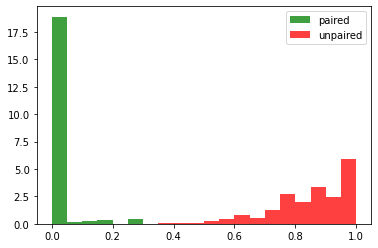

In [230]:
#print(ids)
#print(preds)
loss_paired_modelKlaus = preds[[i for i, x in enumerate(ids) if x==1]]
loss_unpaired_modelKlaus = preds[[i for i, x in enumerate(ids) if x==0]]
print(f'mean loss paired (no augmentation): {np.mean(loss_paired_modelKlaus)}')
print(f'mean loss unpaired (no augmentation): {np.mean(loss_unpaired_modelKlaus)}')


plt.hist(loss_paired_modelKlaus, bins=20, range=[0,1], density=True, facecolor='g', alpha=0.75, label='paired')
plt.hist(loss_unpaired_modelKlaus, bins=20, range=[0,1], density=True, facecolor='r', alpha=0.75, label='unpaired')
plt.xlabel('loss')
plt.ylabel('frequency')
plt.legend()
plt.show()


# Losses on unseen data for training with augmentation

mean loss paired (no augmentation): 0.02035249024629593
mean loss unpaired (no augmentation): 0.8552005887031555


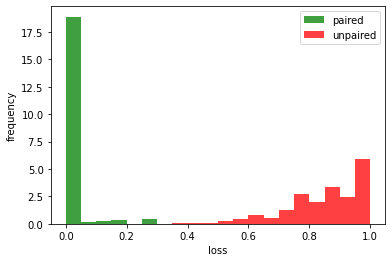

In [231]:
#print(ids)
#print(preds)
loss_paired_modelAaron = preds[[i for i, x in enumerate(ids) if x==1]]
loss_unpaired_modelAaron = preds[[i for i, x in enumerate(ids) if x==0]]
print(f'mean loss paired (no augmentation): {np.mean(loss_paired_modelAaron)}')
print(f'mean loss unpaired (no augmentation): {np.mean(loss_unpaired_modelAaron)}')


plt.hist(loss_paired_modelAaron, bins=20, range=[0,1], density=True, facecolor='g', alpha=0.75, label='paired')
plt.hist(loss_unpaired_modelAaron, bins=20, range=[0,1], density=True, facecolor='r', alpha=0.75, label='unpaired')
plt.legend()
plt.xlabel('loss')
plt.ylabel('frequency')

plt.show()

# Evaluate predictions at division points
* Compre parent in frame t with childs at next t
* 1) Identify all division events (read from 
* 2) Extract all pairs

In [341]:
# for child_id, child_from, child_to, child_parent_id in links:
#     for parent_id, _, parent_to, _ in links:
#         if child_parent_id == parent_id:
#             graph.add_edge((parent_id, parent_to), (child_id, child_from))
            
# edges = graph.edges
# for edge in graph.edges():
#      print(edge)

#for track in tracks:

for track in tracks:
    for i,edge in enumerate(sorted(tracks[0].edges())):
        #print(edge)
        if edge[0][0] != edge[1][0]:
            graph(
            
        
        #     print(f'split in track {i}')

((1, 22), (2, 26))
((1, 22), (3, 26))
((1, 22), (2, 26))
((1, 22), (3, 26))
((1, 22), (2, 26))
((1, 22), (3, 26))
((1, 22), (2, 26))
((1, 22), (3, 26))
((1, 22), (2, 26))
((1, 22), (3, 26))
((1, 22), (2, 26))
((1, 22), (3, 26))
((1, 22), (2, 26))
((1, 22), (3, 26))
((1, 22), (2, 26))
((1, 22), (3, 26))
((1, 22), (2, 26))
((1, 22), (3, 26))
((1, 22), (2, 26))
((1, 22), (3, 26))
((1, 22), (2, 26))
((1, 22), (3, 26))
((1, 22), (2, 26))
((1, 22), (3, 26))
((1, 22), (2, 26))
((1, 22), (3, 26))


# Associate with best prediction in frame+1
* For each cell, check if cell with lowest loss is on GT track`

# Draw tracks with networkx

(-2.0, 2.0, -0.8273896048555001, 1.1483264561383795)

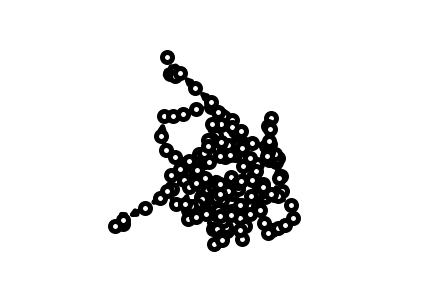

In [263]:
edges = graph.edges

options = {
    "font_size": 10,
    "node_size": 100,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
networkx.draw(tracks[0], **options)
ax = plt.gca()
plt.xlim([-2,2])
ax.margins(0.20)
plt.axis("off")